In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [11]:
df=pd.read_csv("../Datasets/Extracted_AR6_Scenarios_Database_World_ALL_CLIMATE_v1.1.csv")

In [12]:
vars=random.sample(list(df["Variable"].unique()), 4)
scen=random.sample(list(df["Scenario"].unique()), 4)
df.head()

,Model,Scenario,Region,Variable,Unit,1995,1996,1997,1998,1999,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Atmospheric Concentrat...,ppm,358.234794,359.899753,361.630975,363.562233,365.504154,...,374.834039,373.902071,373.026250,372.186323,371.390558,370.639664,369.909231,369.179721,368.439445,367.698091
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Atmospheric Concentrat...,ppm,358.740602,360.381800,362.087955,363.999018,365.909964,...,375.514496,374.559597,373.656183,372.827298,372.035111,371.294216,370.566804,369.830418,369.087668,368.339949
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Atmospheric Concentrat...,ppm,359.475831,361.105111,362.794045,364.678026,366.568898,...,376.794629,375.839151,374.946907,374.105419,373.318078,372.579637,371.828740,371.073816,370.327632,369.576181
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Atmospheric Concentrat...,ppm,360.127932,361.717640,363.389298,365.242314,367.100422,...,377.847938,376.886090,375.983672,375.135336,374.326142,373.547456,372.801978,372.050422,371.287929,370.521764
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Atmospheric Concentrat...,ppm,360.759673,362.342606,363.980326,365.811481,367.647430,...,378.867083,377.904597,376.981245,376.106928,375.286609,374.511211,373.758781,372.995202,372.239996,371.466965


In [13]:
year_cols = [c for c in df.columns if any(ch.isdigit() for ch in str(c))]
year_nums = []

for c in year_cols:
    # Extract the numeric part of the column name
    num = "".join(ch for ch in str(c) if ch.isdigit())
    if num.isdigit():
        year_nums.append(int(num))
    else:
        year_nums.append(np.nan)

# Map original col → numeric year
col_map = dict(zip(year_cols, year_nums))

# 2️⃣ Drop non-year columns
non_year_cols = [c for c in df.columns if c not in year_cols]

# 3️⃣ Convert year columns to numeric, aggregate by 5-year bins
df_years = df[year_cols].copy()
df_years.columns = [col_map[c] for c in year_cols]

# Remove any NaNs in columns (non-year ones)
df_years = df_years.loc[:, ~pd.isna(df_years.columns)]

# Build 5-year mapping: 1995–1999 → 1995, 2000–2004 → 2000, etc.
def five_year_bin(y):
    return 1995 + 5 * ((y - 1995) // 5)

mapping = {y: five_year_bin(y) for y in df_years.columns}

# 4️⃣ Rename and take mean per bin
df_5yr = (
    df_years.rename(columns=mapping)
            .groupby(level=0, axis=1)
            .mean()
)

# 5️⃣ Combine back with original metadata columns
df_final = pd.concat([df[non_year_cols], df_5yr], axis=1)

print(df_final.filter(regex=r"^\d").head())

         1995        2000        2005        2010        2015        2020  \
0  361.766382  370.792971  380.842164  392.306218  404.559043  416.548477   
1  362.223868  371.147012  381.077852  392.401886  404.697239  416.857114   
2  362.924382  371.691722  381.431867  392.574349  404.924434  417.376233   
3  363.515521  372.145599  381.743908  392.724085  405.114163  417.836775   
4  364.108303  372.605347  382.045419  392.879323  405.302795  418.300440   

         2025        2030        2035        2040  ...        2055  \
0  424.313509  427.268396  426.803666  423.692797  ...  408.971651   
1  424.796917  427.842822  427.449454  424.386101  ...  409.748945   
2  425.636310  428.982811  428.827171  425.948424  ...  411.469563   
3  426.364905  429.929018  429.957625  427.211069  ...  412.761416   
4  427.126321  430.938509  431.162282  428.552966  ...  414.275298   

         2060        2065        2070        2075        2080        2085  \
0  403.666919  398.439424  393.207810  

/var/folders/y0/b8933myn6y976phjbj_5t5j00000gn/T/ipykernel_45945/3408645165.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(level=0, axis=1)


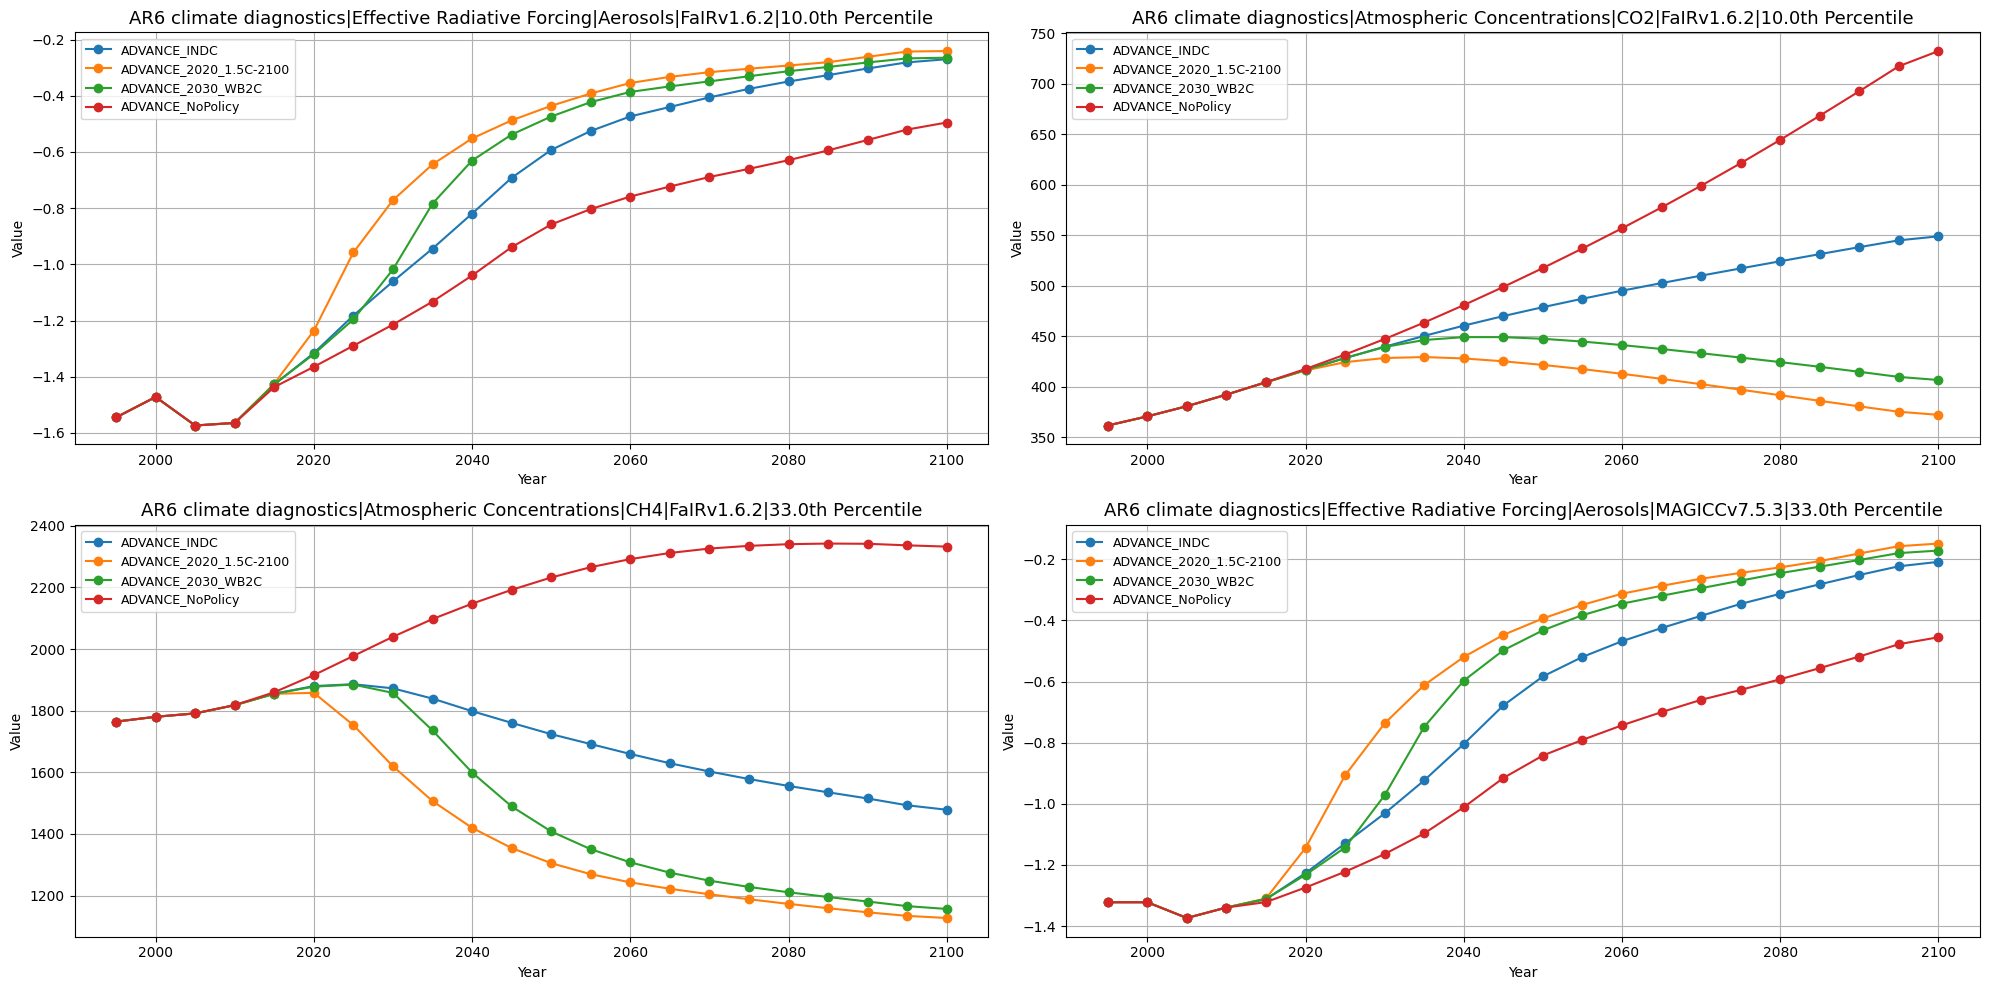

In [14]:
# Use df_final (your 5-year averaged DF)
data = df_final  # alias for clarity

# 1) Detect year columns in df_final and sort them
year_cols = [c for c in data.columns if str(c).strip().isdigit()]
if not year_cols:
    raise ValueError("No year columns detected in df_final. Make sure columns like '1995','2000',... exist.")

year_cols = sorted(year_cols, key=lambda x: int(str(x)))
years = np.array(list(map(int, year_cols)))   # e.g. [1995, 2000, 2005, ...]


# 2) Prepare figure (2x2)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

# 3) Plotting loop with robust y extraction from df_final
for i, var in enumerate(vars):
    ax = axes[i]
    subdf = data[data["Variable"] == var]

    for s in scen:
        temp = subdf[subdf["Scenario"] == s]

        if temp.empty:
            # no rows for this combo -> skip (optionally mark)
            # ax.text(0.5, 0.5, f"No data for {s}", transform=ax.transAxes, ha="center")
            continue

        # Convert year columns to numeric (coerce errors to NaN)
        temp_years = temp[year_cols].apply(pd.to_numeric, errors="coerce")

        # Aggregate if multiple rows (mean). If you want the first row use .iloc[0]
        if temp_years.shape[0] == 1:
            y = temp_years.iloc[0].to_numpy()
        else:
            y = temp_years.mean(axis=0).to_numpy()

        if y.shape[0] != years.shape[0]:
            print(f"Shape mismatch for Variable='{var}', Scenario='{s}': x={years.shape}, y={y.shape}")
            continue

        if np.isnan(y).any():
            y = pd.Series(y, index=years).interpolate(method='linear', limit_direction='both').to_numpy()

        ax.plot(years, y, marker='o', label=s)

    ax.set_title(var, fontsize=13)
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
    ax.legend(fontsize=9)
    ax.grid(True)

# Hide any unused axes if vars < 4
for j in range(len(vars), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [15]:
df["Variable"].unique()

array(['AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|10.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|16.7th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|33.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|67.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|83.3th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|90.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|FaIRv1.6.2|95.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|MAGICCv7.5.3|10.0th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentrations|CO2|MAGICCv7.5.3|16.7th Percentile',
       'AR6 climate diagnostics|Atmospheric Concentratio

In [16]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume df_final is already defined as your 5-year averaged DataFrame
# Fallback defaults if not defined
try:
    vars  # noqa: F821
except NameError:
    vars = list(df_final["Variable"].unique()[:4])

try:
    scen  # noqa: F821
except NameError:
    scen = list(df_final["Scenario"].unique()[:4])

# Accept up to 4 variables
vars = list(vars)[:4]
scen = list(scen)

# Data alias
data = df_final.copy()

# Detect year columns in df_final (should be 1995, 2000, 2005, ...)
year_cols = [c for c in data.columns if str(c).strip().isdigit()]
if not year_cols:
    raise ValueError("No year-like columns detected in df_final (expect columns like '1995','2000',...).")
year_cols = sorted(year_cols, key=lambda x: int(str(x)))
years = list(map(int, year_cols))

# Helper: get y-values for (var, scenario) from vals or data
def get_y(var, scenario):
    # 1) Try to use externally-provided `vals` if present
    if 'vals' in globals() and vals is not None:
        try:
            if (var, scenario) in vals:
                return np.asarray(vals[(var, scenario)])
            if var in vals and scenario in vals[var]:
                return np.asarray(vals[var][scenario])
        except Exception:
            pass
    # 2) Fallback: compute from df_final (mean across duplicate rows)
    subdf = data[data["Variable"] == var]
    temp = subdf[subdf["Scenario"] == scenario]
    if temp.empty:
        return None
    vals_df = temp[year_cols].apply(pd.to_numeric, errors="coerce")
    if vals_df.shape[0] == 1:
        y = vals_df.iloc[0].to_numpy()
    else:
        y = vals_df.mean(axis=0).to_numpy()
    # Interpolate NaNs so lines are continuous
    y = pd.Series(y, index=years).interpolate(method="linear", limit_direction="both").to_numpy()
    return y

# Create 2x2 subplots and adjust spacing to avoid title overlap
rows, cols = 2, 2
subplot_titles = [v for v in vars] + [""] * (rows * cols - len(vars))

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=subplot_titles,
    horizontal_spacing=0.08,
    vertical_spacing=0.22  # increase vertical spacing to avoid overlap
)

# Add traces. Show legend only in the first subplot; use legendgroup to group same scenario traces.
for i, var in enumerate(vars):
    r = i // cols + 1
    c = i % cols + 1

    for s in scen:
        y = get_y(var, s)
        if y is None:
            continue

        y = np.asarray(y).flatten()
        if y.shape[0] != len(years):
            print(f"Skipping ({var}, {s}) due to length mismatch: {y.shape[0]} vs {len(years)}")
            continue

        show_legend = (i == 0)  # only first subplot displays the legend entries

        fig.add_trace(
            go.Scatter(
                x=years,
                y=y,
                mode="lines+markers",
                name=str(s),
                legendgroup=str(s),
                showlegend=show_legend,
                hovertemplate=f"Var: {var}<br>Scenario: {s}<br>Year: %{{x}}<br>Value: %{{y:.3f}}"
            ),
            row=r, col=c
        )

    fig.update_xaxes(title_text="Year", row=r, col=c)
    fig.update_yaxes(title_text="Value", row=r, col=c)

# Hide any empty subplots if less than 4 vars
total_plots = rows * cols
if len(vars) < total_plots:
    for j in range(len(vars), total_plots):
        r = j // cols + 1
        c = j % cols + 1
        fig.update_xaxes(visible=False, row=r, col=c)
        fig.update_yaxes(visible=False, row=r, col=c)

# Layout tuning: larger top margin and adjusted annotation fonts/positions to avoid overlap
fig.update_layout(
    height=880,
    width=1250,
    title_text="2×2 Variables × Scenarios (5-year averages)",
    showlegend=True,
    margin=dict(t=150, b=60, l=60, r=40)
)

# Reduce subplot title font size and nudge them slightly upward
for ann in fig.layout.annotations:
    ann.font = dict(size=14)   # reduce title font
    # nudge title upward a bit to give more breathing room
    try:
        ann.y += 0.03
    except Exception:
        pass

# Optionally: make legend items clickable and affect all traces with same scenario (legendgroup used)
fig.update_layout(legend=dict(title="Scenarios", yanchor="top", y=0.95, x=1.02))

fig.show()


In [17]:
import json

# df_final is your 5-year averaged DataFrame
# We will produce:
# { "years": [1995,2000,...], "vars": [...], "scenarios": [...],
#   "data": { "<var>": { "<scenario>": [yvals...] , ... }, ... } }

# Detect year columns
year_cols = [c for c in df_final.columns if str(c).strip().isdigit()]
year_cols = sorted(year_cols, key=lambda x: int(str(x)))
years = list(map(int, year_cols))

vars_list = sorted(df_final["Variable"].unique().tolist())
scen_list = sorted(df_final["Scenario"].unique().tolist())

payload = {"years": years, "vars": vars_list, "scenarios": scen_list, "data": {}}

for v in vars_list:
    payload["data"][v] = {}
    subdf_v = df_final[df_final["Variable"] == v]
    for s in scen_list:
        subdf_vs = subdf_v[subdf_v["Scenario"] == s]
        if subdf_vs.empty:
            continue
        arr = subdf_vs[year_cols].apply(pd.to_numeric, errors="coerce")
        # aggregate by mean if multiple rows
        if arr.shape[0] > 1:
            y = arr.mean(axis=0).to_numpy()
        else:
            y = arr.iloc[0].to_numpy()
        # convert NaNs to None so JSON is small and JS can handle it
        y = [None if (pd.isna(x)) else float(x) for x in y]
        payload["data"][v][s] = y

# Save to disk to a folder 'public' (Next.js serves public/* as static)
import os
os.makedirs("public", exist_ok=True)
with open("public/data.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)

print("Wrote public/data.json")


Wrote public/data.json
